라이브러리

In [129]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error, pairwise_distances
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_name = 'powerTest_standard2'

데이터셋 설정

In [130]:
power = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/powerconsumption.csv")
power['Datetime'] = pd.to_datetime(power['Datetime'], format='%m/%d/%Y %H:%M', errors='raise')
power.describe()
power.set_index('Datetime', inplace=True)


In [131]:
start_date = '2017-01-01'
end_date = '2017-11-30'
power_test = power.loc[start_date:end_date]

In [132]:
start_date = '2017-12-01'
end_date = '2017-12-30'
power_validation= power.loc[start_date:end_date]

In [133]:
power_np = power_test[['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1']].values

scaler = StandardScaler()
X_standardized = scaler.fit_transform(power_np)

power_test = pd.DataFrame({'Datetime': power_test.index, 'Temperature': X_standardized[:, 0],'Humidity': X_standardized[:, 1],'WindSpeed': X_standardized[:, 2],'GeneralDiffuseFlows': X_standardized[:, 3],'DiffuseFlows': X_standardized[:, 4],'PowerConsumption_Zone1': X_standardized[:, 5]})
power_test.set_index('Datetime', inplace=True)

power_test

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1
Datetime,,,,,,
2017-01-01 00:00:00,-2.223696,0.358399,-0.853479,-0.702883,-0.614205,0.197966
2017-01-01 00:10:00,-2.248990,0.402972,-0.853479,-0.702812,-0.614471,-0.396445
2017-01-01 00:20:00,-2.266608,0.402972,-0.854741,-0.702842,-0.614354,-0.492675
2017-01-01 00:30:00,-2.300101,0.434809,-0.853479,-0.702735,-0.614385,-0.618710
2017-01-01 00:40:00,-2.334989,0.479382,-0.854320,-0.702894,-0.614471,-0.743894
...,...,...,...,...,...,...
2017-11-30 23:10:00,-1.161176,1.128871,-0.857263,-0.702883,-0.614385,-0.181582
2017-11-30 23:20:00,-1.166409,1.141606,-0.858525,-0.702816,-0.614729,-0.285946
2017-11-30 23:30:00,-1.164665,1.147973,-0.858525,-0.702827,-0.614323,-0.385997


In [134]:
power_test_X = power_test[['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1']]
power_test_y = power_test[['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1']]

In [135]:
power_validation_X = power_validation[['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1']]
power_validation_y = power_validation[['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1']]

In [136]:
power_test_X_chunks = []
power_test_y_chunks = []

for i in range(0, len(power_test_X) - 35):
    power_test_X_chunks.append(np.array(power_test_X.iloc[i:i+36].values, dtype=np.float64))
power_test_X_chunks = np.array(power_test_X_chunks, dtype=np.float64)

for i in range(0, len(power_test_y) - 35):
    power_test_y_chunks.append(np.array(power_test_y.iloc[i:i+36].values, dtype=np.float64))
power_test_y_chunks = np.array(power_test_y_chunks, dtype=np.float64)

In [137]:
power_validation_X_chunks = []
power_validation_y_chunks = []

for i in range(0, len(power_validation_X) - 35):
    power_validation_X_chunks.append(np.array(power_validation_X.iloc[i:i+36].values, dtype=np.float64))
power_validation_X_chunks = np.array(power_validation_X_chunks, dtype=np.float64)

for i in range(0, len(power_validation_y) - 35):
    power_validation_y_chunks.append(np.array(power_validation_y.iloc[i:i+36].values, dtype=np.float64))
power_validation_y_chunks = np.array(power_validation_y_chunks, dtype=np.float64)

In [138]:
# shape확인
nCar = power_test_X_chunks.shape[0] # 데이터 개수
nVar = power_test_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_test_y_chunks.shape[0] # 데이터 개수
nVar = power_test_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_validation_X_chunks.shape[0] # 데이터 개수
nVar = power_validation_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_validation_y_chunks.shape[0] # 데이터 개수
nVar = power_validation_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 48061 nVar: 6
nCar: 48061 nVar: 36
nCar: 4285 nVar: 6
nCar: 4285 nVar: 36


In [139]:
power_test_X_chunks_crop = power_test_X_chunks[:-36]
power_test_y_chunks_crop = power_test_y_chunks[36:]

power_validation_X_chunks_crop = power_validation_X_chunks[:-36]
power_validation_y_chunks_crop = power_validation_y_chunks[36:]

In [140]:
# shape확인
nCar = power_test_X_chunks_crop.shape[0] # 데이터 개수
nVar = power_test_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_test_y_chunks_crop.shape[0] # 데이터 개수
nVar = power_test_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_validation_X_chunks_crop.shape[0] # 데이터 개수
nVar = power_validation_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_validation_y_chunks_crop.shape[0] # 데이터 개수
nVar = power_validation_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

power_test_y_chunks_crop.shape

nCar: 48025 nVar: 6
nCar: 48025 nVar: 36
nCar: 4249 nVar: 6
nCar: 4249 nVar: 36


(48025, 36, 6)

In [141]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [142]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(128, input_shape=(36, 6), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(6, activation='linear'))
 
model.summary()

model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

checkpoint = ModelCheckpoint(model_name+'.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

hist = model.fit(power_test_X_chunks_crop, power_test_y_chunks_crop, epochs = 1000, batch_size = 36, validation_data=(power_validation_X_chunks_crop, power_validation_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 36, 128)           69120     
                                                                 
 lstm_40 (LSTM)              (None, 36, 64)            49408     
                                                                 
 lstm_41 (LSTM)              (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 6)                 198       
                                                                 
Total params: 131,142
Trainable params: 131,142
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1335/1335 [==============================] - 71s 49ms/step - loss: 0.9995 - mae: 0.8308 - r_squared: -0.0053 - val_loss: 147377360.0000 - val_mae: 4884.6484 - val_r_s

In [143]:
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[-0.0512257  -0.01214607 -0.04528997 ... -0.02539056  0.00722689
   0.07362917]
 [ 0.07109436  0.0723139   0.01985119 ... -0.10460906 -0.02651905
  -0.07758354]
 [-0.02553927 -0.06422719 -0.06090388 ...  0.01195111 -0.08640015
   0.08861689]
 [ 0.0048585   0.024811   -0.0880193  ...  0.05454156 -0.08285961
   0.03275066]
 [ 0.00275295 -0.04481521  0.08021015 ...  0.04309199 -0.0114438
   0.02750548]
 [-0.00949779 -0.04113292 -0.00540411 ...  0.01306295  0.05969338
  -0.02586738]]


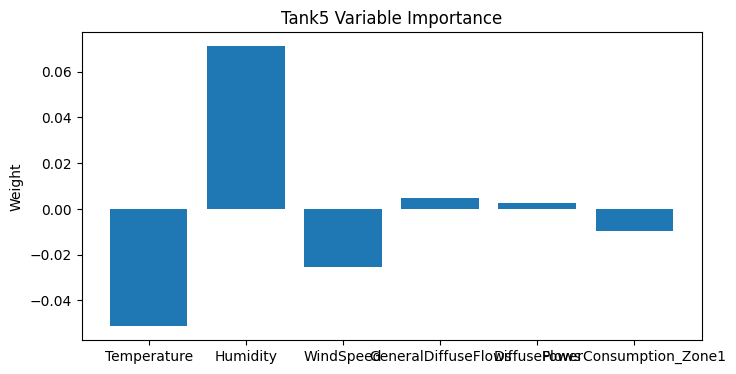

In [144]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(6), weights[:, 0])
ax.set_xticks(range(6))
ax.set_xticklabels(['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1'])
ax.set_ylabel('Weight')
ax.set_title('Tank5 Variable Importance')
plt.show()

In [165]:
# 모델 평가 함수
def grapeNEva(X_test_shape, y_test, y_test_shape):
    X_pred = model.predict(X_test_shape)
    print(X_pred.shape)
    X_pred = scaler.inverse_transform(X_pred)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.T

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    #plt.plot(y_test.index, y_test['PowerConsumption_Zone1'], label='power')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred[0], label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('power')
    plt.title('test')
    plt.legend(['power','prediction'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [166]:
X_test = power_validation_X.loc['2017-12-01 00:00':'2017-12-30 17:50']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 36, 6))
print(X_test_reshape.shape)

(119, 36, 6)


In [167]:
y_test = power_validation_y.loc['2017-12-01 06:00':'2017-12-30 23:50']

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 36, 6))

print(y_test.shape)
print(y_test_reshape.shape)

(4284, 6)
(119, 36, 6)


In [168]:
y_test.index

DatetimeIndex(['2017-12-01 06:00:00', '2017-12-01 06:10:00',
               '2017-12-01 06:20:00', '2017-12-01 06:30:00',
               '2017-12-01 06:40:00', '2017-12-01 06:50:00',
               '2017-12-01 07:00:00', '2017-12-01 07:10:00',
               '2017-12-01 07:20:00', '2017-12-01 07:30:00',
               ...
               '2017-12-30 22:20:00', '2017-12-30 22:30:00',
               '2017-12-30 22:40:00', '2017-12-30 22:50:00',
               '2017-12-30 23:00:00', '2017-12-30 23:10:00',
               '2017-12-30 23:20:00', '2017-12-30 23:30:00',
               '2017-12-30 23:40:00', '2017-12-30 23:50:00'],
              dtype='datetime64[ns]', name='Datetime', length=4284, freq=None)

4/4 [==============================] - 0s 21ms/step
(119, 6)


ValueError: x and y must have same first dimension, but have shapes (4284,) and (119,)

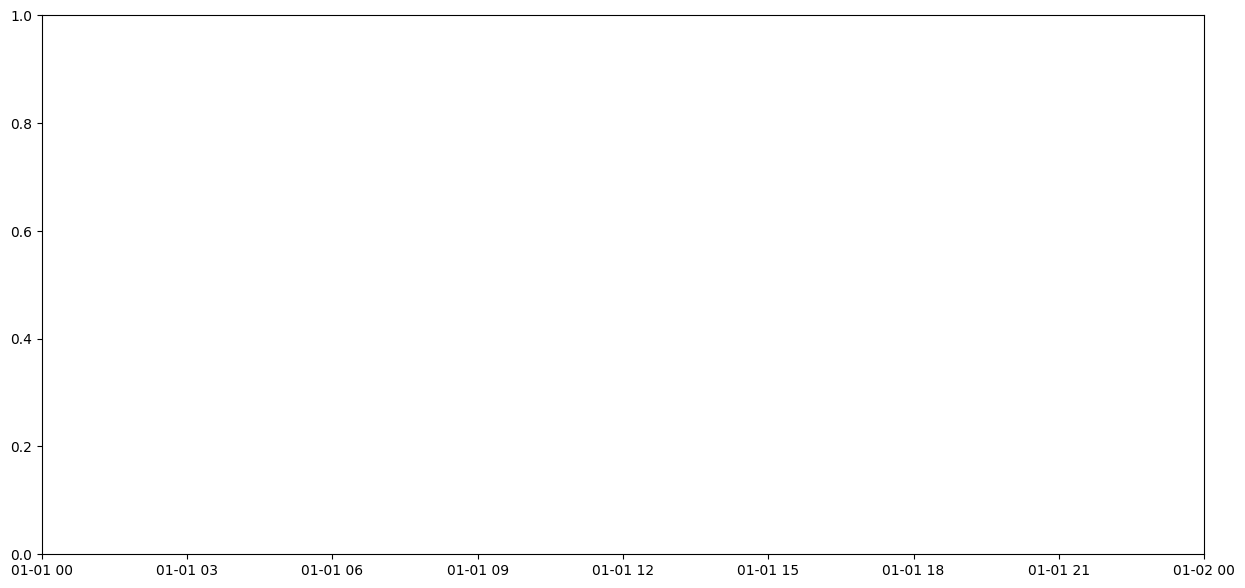

In [169]:
grapeNEva(X_test_reshape, y_test, y_test_reshape)

nCar: 7 nVar: 36
nCar: 252 nVar: 1
nCar: 7 nVar: 36
1/1 [==============================] - 0s 31ms/step
252


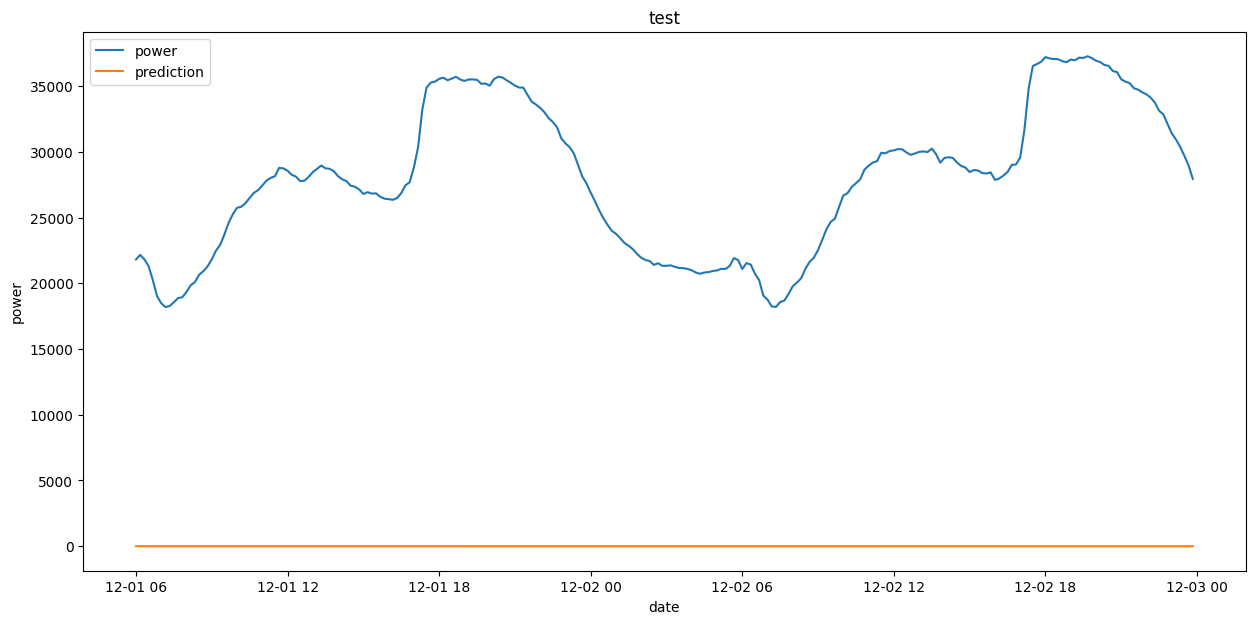

1/1 [==============================] - 0s 32ms/step - loss: 813984640.0000 - mae: 27984.0215 - r_squared: -25.3611
MSE // MAE // R-squared  [813984640.0, 27984.021484375, -25.361059188842773]


In [30]:
X_test = power_validation_X.loc['2017-12-01 00:00':'2017-12-02 17:50']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 36, 6))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test = power_validation_y.loc['2017-12-01 06:00':'2017-12-02 23:50']

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 36, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(X_test_reshape, y_test, y_test_reshape)